# Setup environment

In [1]:
import numpy as np
from numpy.linalg import inv
import math

import matplotlib.pyplot as plt
import seaborn as sns

import time

# Dataset

In [2]:
def add_noise(arr, level, v=True):
  noise = np.random.normal(0, level/2, len(arr))
  if v:
    plt.hist(noise)
    plt.show()

  arr = arr + noise
  
  return arr

In [3]:
def plot_train_data(x1, x2):
    # scatter plot:
    plt.scatter(x1, np.ones_like(x1), s=200, c='r', alpha=0.5, label="Class 0")
    plt.scatter(x2, np.ones_like(x2), s=200, c='c', alpha=0.5, label="Class 1")
    # Legend on classes
    plt.legend()
    plt.ylim(0, 2)
    plt.show()


In [4]:
def generate_classes(Y):
    #limit = Y.max()/2 
    limit = np.median(Y)
    Y_aux = []
    for y in Y:
      if y > limit:
        Y_aux.append(1)
      else:
        Y_aux.append(0)
    Y = np.array(Y_aux)
    return Y

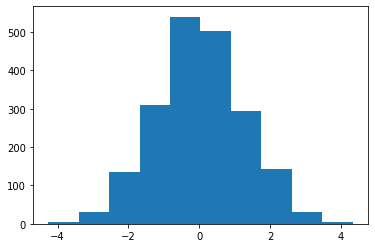

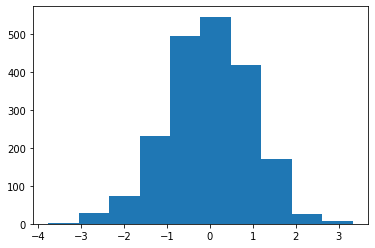

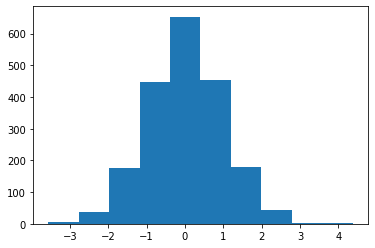

In [5]:
# Create random input and output data
x1 = np.random.normal(10, 10/2, 2000)
x2 = np.random.normal(15, 10/2, 2000)

# Create output data
Y = (1 + (x1 * 3) + (x2 * 6)).T

Y = add_noise(x1, Y.max()/100)
Y = generate_classes(Y)

# Add noise to x
x1 = add_noise(x1, 2)
x2 = add_noise(x2, 2)

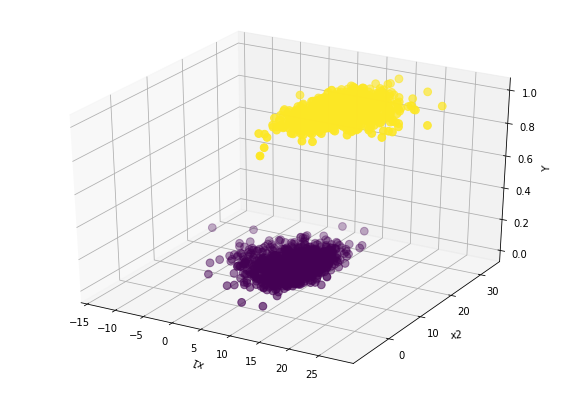

In [6]:
# Create the instance
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x1, x2, Y, s=60, c=Y)

# axis: 'x', 'y' y 'z'
ax.set_xlabel('x1', fontsize=10, rotation=155)
ax.set_ylabel('x2', fontsize=10, rotation=5)
ax.set_zlabel(r'Y', fontsize=10, rotation=87)

plt.show()

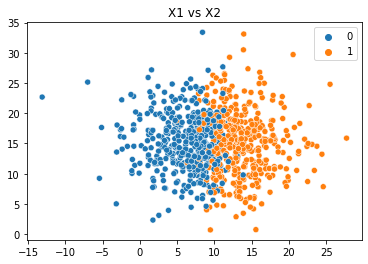

In [7]:
# x1 vs y
sns.scatterplot(x=x1[:int(len(x1)*.4)], y=x2[:int(len(x2)*.4)], hue=Y[:int(len(Y)*.4)])
plt.title("X1 vs X2")
plt.show()

In [8]:
# Generate X matrix:
b = np.ones(2000)
X = np.stack([x1, x2]).T
X.shape

(2000, 2)

In [9]:
def split_train_test(x, y, train_set=80):
  index = np.arange(len(y))
  np.random.shuffle(index)

  print(f'The train set will be the {train_set}% of the dataset')
  
  # Test:
  test_index = index[int(len(y)*.8):]
  try:
    x_test = x[test_index, :]
  except:
    x_test = x[test_index]
  y_test = y[test_index]

  # Train:
  train_index = index[:int(len(y)*.8)]
  try:
    x = x[train_index, :]
  except:
    x = x[train_index]

  y = y[train_index]

  print(f'The x train shape is: {x.shape} and y is: {y.shape}')
  print(f'The x test shape is: {x_test.shape} and y is: {y_test.shape}')

  return x, y, x_test, y_test

In [10]:
X, Y, x_test, y_test = split_train_test(X, Y)

The train set will be the 80% of the dataset
The x train shape is: (1600, 2) and y is: (1600,)
The x test shape is: (400, 2) and y is: (400,)


# Models

## Logistic Regression

Hypothesis:

We have some data modeled by the equation:

$$
y_i = sigmoid(LR)
$$

In the equation the components are:


#### 1. **Linear regression is deffined by**:
$$
LR = \beta_{0} + \sum_{j=1}^{n} \beta_{j} \cdot X_{i,j} + \epsilon_{i}
$$

Which can be written as:

* Variables:
$$
X = \begin{bmatrix}
1 & x_{11} & x_{12}  & ... & x_{1n} \\
1 & x_{21} & x_{22}  & ... & x_{2n}\\
... & ... & ...  & ... & ...\\ 
1 & x_{n1} & x_{n2}  & ... & x_{3n}\\
\end{bmatrix}
$$

* Weights: 
$$
\beta = \begin{bmatrix}
\beta_{0} & \beta_{1} & \beta_{2} & \beta_{n}
\end{bmatrix}
$$


* Random error: 

$$
\epsilon = \begin{bmatrix}
\epsilon_{0} & \epsilon_{1} & \epsilon_{2} & \epsilon_{n}
\end{bmatrix}
$$

So that:

$$
H(\beta) = \beta^{T} \cdot X + \epsilon^{T} =  \beta_{0} + \beta_{1} \cdot  X_{1} + \beta_{2} \cdot  X_{2} + ... + \beta_{n} \cdot  X_{n}
$$

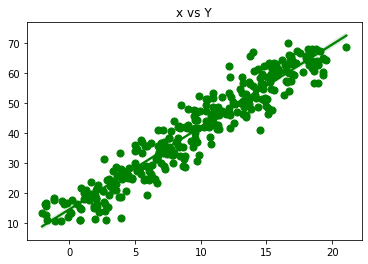

In [11]:
def exaple_linear_regression():
  x = np.random.randint(0, 20, 400)
  
  # Create output data
  y = (12 + (x * 3)).T

  # Add noise to x and y
  x = add_noise(x, 3, v=False)
  y = add_noise(y, 3, v=False)

  # x1 vs y
  sns.regplot(x=x[:int(len(x)*.8)], y=y[:int(len(y)*.8)], color='Green', x_estimator=np.mean)
  plt.title("x vs Y")
  plt.show()

exaple_linear_regression()

#### 2. **Sigmoid function**:

$$
sigmoid(LR) = \frac{1}{1+e^{-LR}}
$$

In [12]:
# Sigmoid Function
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

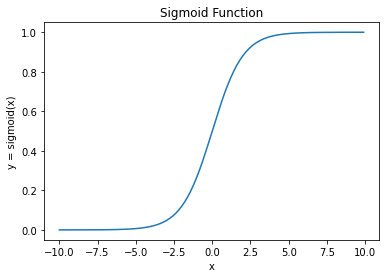

In [13]:
def plot_sigmoid():
  values = np.arange(-10, 10, 0.1)

  plt.plot(values, sigmoid(values))
  plt.xlabel('x')
  plt.ylabel('y = sigmoid(x)')
  plt.title('Sigmoid Function')
  plt.show()

plot_sigmoid()

### We will solve using SGD

for that we deffine an error function:

#### **Categorical Cross Entropy**:

$$
Cross Entropy = -[y\log(y_i) + (1 - y)\log(1 - y_i)|
$$

In [14]:
def Cross_Entropy(y, y_hat):
    if y == 1:
      return -np.log(y_hat)
    else:
      return -np.log(1 - y_hat)

In [15]:
def get_Cross_Entropy(Y, Y_hat):
  cross_entropy = []
  for y, y_hat in zip(Y, Y_hat):
    loss = Cross_Entropy(y, y_hat)
    cross_entropy.append(loss)

  return np.array(cross_entropy)

1. Given the logistic regression function:

$$
\hat{y} = sigmoid(\beta_{0} + \sum_{j=1}^{n} \beta_{j} \cdot X_{i,j} + \epsilon_{i})
$$

2. And the error function:

$$ \epsilon = \sum_{j=1}^{n}  -[y_j\log(\hat{y_j}) + (1 - y_j)\log(1 - \hat{y_j})]$$

We have the gradient given by:


To minimize:
$$
SGD = - \frac{\partial }{\partial \beta}(\epsilon(\hat{y}(X,\beta))) * lr
$$

$$
SGD = - \frac{\partial }{\partial \hat{y}}(\epsilon(\hat{y})) *  \frac{\partial }{\partial \beta}(\hat{y}(X,\beta)) *lr
$$

Finally we have:

$(1)$
$$ 
- \frac{\partial }{\partial \hat{y}}(\epsilon(\hat{y})) = \frac{\partial }{\partial \hat{y}}([y_j\log(\hat{y_j}) + (1 - y_j)\log(1 - \hat{y_j})|)
$$

where:

$$
\frac{\partial }{\partial x}{\log{x}} = \frac{1 }{x \ln{10}}
$$

so:

$(1)$
$$
- \frac{\partial }{\partial \hat{y}}(\epsilon(\hat{y})) = \frac{y}{\hat{y}} + \frac{1-y}{1-\hat{y}}
$$

In code:

In [16]:
def d_Cross_Entropy(y, y_hat):
    if y == 1:
      return -1/y_hat
    else:
      return 1 / (1 - y_hat)

In [17]:
def get_d_Cross_Entropy(Y, Y_hat):
  cross_entropy = []
  for y, y_hat in zip(Y, Y_hat):
    loss = d_Cross_Entropy(y, y_hat)
    cross_entropy.append(loss)

  return np.array(cross_entropy)

Now we need to calculate the second half of the equation:


$(2)$

$$\frac{\partial }{\partial \beta}(\hat{y}(X,\beta)) = \frac{\partial }{\partial \beta}(sigmoid(\hat{y}(X,\beta))$$

where:
$$\frac{\partial }{\partial \beta}(sigmoid(\beta)) = sigmoid(\beta)(1-sigmoid(\beta))$$

In code:

In [18]:
def d_sigmoid(B):
    return B*(1-B)

### So SGD will be:

In [19]:
B0 = 0.
B1 = 0.
B2 = 0.

learning_rate = 3e-6

st = time.time()

for t in range(5000):
    # Forward pass: compute predicted y
    # sigmoid(y) = sigmoid(B0 + B1 x1 + B2 x2)
    y_pred = B0 + B1*X[:, 0] + + B2*X[:, 1]
    y_pred = sigmoid(y_pred)

    # Compute and print loss
    loss = get_Cross_Entropy(Y, y_pred).sum()
    if t % 100 == 99:
        print(t, loss)

    # Backprop to compute gradients of a, b, c, d with respect to loss
    grad_y_pred = get_d_Cross_Entropy(Y, y_pred)
    grad_B0 = grad_y_pred.sum()
    grad_B1 = (grad_y_pred * d_sigmoid(y_pred) * X[:, 0]).sum()
    grad_B2 = (grad_y_pred * d_sigmoid(y_pred) * X[:, 1]).sum()

    # Update weights
    B0 -= learning_rate * grad_B0
    B1 -= learning_rate * grad_B1
    B2 -= learning_rate * grad_B2


# get the end time
et = time.time()
# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

print(f'Result: y = {B0} + {B1} x1 + {B2} x2')

99 693.7263834210155
199 662.4345347996028
299 647.8284877897385
399 636.1424302028995
499 625.5417285180497
599 615.7056513495462
699 606.5498856742306
799 598.0199955691394
899 590.0618961414286
999 582.6219071629002
1099 575.6495685185341
1199 569.0991867471669
1299 562.9302132271741
1399 557.106995126359
1499 551.5982716433625
1599 546.3766111638997
1699 541.4178771996586
1799 536.7007553931362
1899 532.2063479657897
1999 527.9178311756498
2099 523.8201676915637
2199 519.8998652898413
2299 516.14477402698
2399 512.5439151711403
2499 509.0873363159611
2599 505.76598811507216
2699 502.5716189285754
2799 499.4966843700622
2899 496.53426930518253
2999 493.67802030394404
3099 490.92208691037604
3199 488.2610703832386
3299 485.68997879490274
3399 483.20418756416655
3499 480.7994046518812
3599 478.4716397731072
3699 476.217177081802
3799 474.03255086822367
3899 471.9145238788393
3999 469.8600679263267
4099 467.86634650546154
4199 465.9306991710521
4299 464.0506274680092
4399 462.223782232

### Error: 

Now we are going to measure the performance of the model:

#### Accuracy


$$
Accuracy = \frac{TP + TN}{TP + FP + TN + FN}
$$

In [20]:
def get_accuracy(y, y_hat):
  accuracy = np.sum(y_hat==y)/len(y)
  print(f'The accuracy is: {accuracy}')
  return accuracy

In [21]:
def evaluate(x_test, y_test, B):
  b = np.ones(len(x_test))
  x_test_arr = np.stack([b, x_test[:, 0], x_test[:, 1]]).T
  y_hat = sigmoid(np.sum(x_test_arr * B, axis=1))
  y_hat = [0 if y <= 0.5 else 1 for y in y_hat]
  get_accuracy(y_test, y_hat)

In [22]:
evaluate(x_test, y_test, np.array([B0, B1, B2]))

The accuracy is: 0.89


In [23]:
B0 = 0.
B1 = 0.
B2 = 0.

learning_rate = 3e-8

st = time.time()

for t in range(10000):
    # Forward pass: compute predicted y
    # sigmoid(y) = sigmoid(B0 + B1 x1 + B2 x2^2)
    y_pred = B0 + B1 * X[:, 0] + B2 * X[:, 1] ** 2
    y_pred = sigmoid(y_pred)

    # Compute and print loss
    loss = get_Cross_Entropy(Y, y_pred).sum()
    if t % 100 == 99:
        print(t, loss)

    # Backprop to compute gradients of a, b, c, d with respect to loss
    grad_y_pred = get_d_Cross_Entropy(Y, y_pred)
    grad_B0 = grad_y_pred.sum()
    grad_B1 = (grad_y_pred * d_sigmoid(y_pred) * X[:, 0]).sum()
    grad_B2 = (grad_y_pred * d_sigmoid(y_pred) * X[:, 1] ** 2).sum()

    # Update weights
    B0 -= learning_rate * grad_B0
    B1 -= learning_rate * grad_B1
    B2 -= learning_rate * grad_B2


# get the end time
et = time.time()
# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

print(f'Result: y = {B0} + {B1} x1 + {B2} x2^2')

99 1082.137516193806
199 1058.2898310975334
299 1037.2995667764249
399 1018.7910631395591
499 1002.4351526069117
599 987.9459715931478
699 975.0767523308521
799 963.6152677722025
899 953.3793537910694
999 944.212746970708
1099 935.9813499655121
1199 928.5699573056054
1299 921.8794289000421
1399 915.824274950993
1499 910.3306061081532
1599 905.3344007565094
1699 900.7800436741096
1799 896.6190946741375
1899 892.809250945864
1999 889.313471908449
2099 886.0992401236623
2199 883.1379360211595
2299 880.4043078329369
2399 877.8760212337394
2499 875.5332757923073
2599 873.3584775159413
2699 871.3359585800341
2799 869.4517368327596
2899 867.6933089042823
2999 866.049471773912
3099 864.5101684949972
3199 863.0663544773724
3299 861.709881306795
3399 860.4333955614318
3499 859.2302504846916
3599 858.094428705936
3699 857.0204744776648
3799 856.0034341292966
3899 855.0388036315849
3999 854.1224823284799
4099 853.2507320301872
4199 852.4201407766523
4299 851.6275906782975
4399 850.8702293235103
44

In [ ]:
evaluate(x_test, y_test, np.array([B0, B1, B2]))

## Sklearn

#### Create dataset

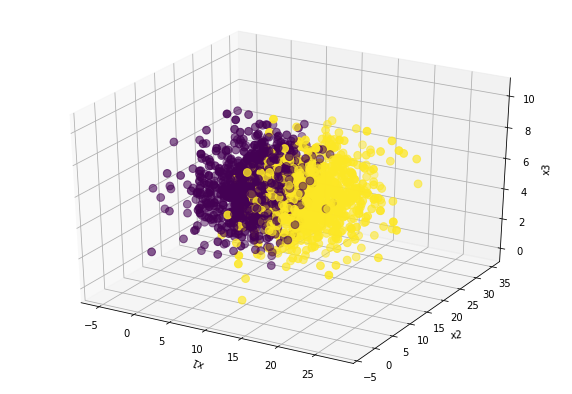

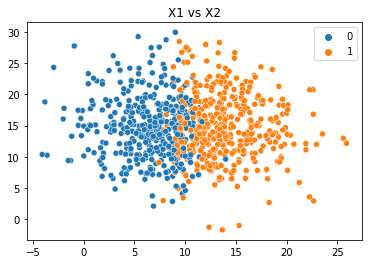

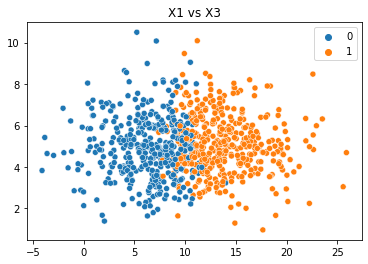

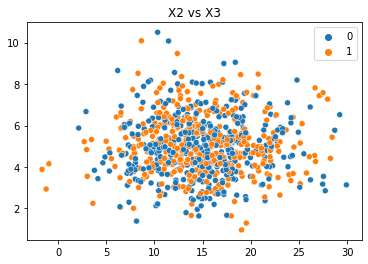

The train set will be the 80% of the dataset
The x train shape is: (1600, 3) and y is: (1600,)
The x test shape is: (400, 3) and y is: (400,)


In [25]:
# Dataset:
# Create random input and output data
x1 = np.random.normal(10, 10/2, 2000)
x2 = np.random.normal(15, 10/2, 2000)
x3 = np.random.normal(5, 3/2, 2000)

X = np.stack([x1, x2, x3]).T

# Create output data
Y = (1 + (x1 * 3) + (x2 * 6) + (x3 * 1)).T

Y = add_noise(x1, Y.max()/100, v=False)
Y = generate_classes(Y)

# Add noise to x
X[:, 0] = add_noise(X[:, 0], 1, v=False)
X[:, 1] = add_noise(X[:, 1], 2, v=False)
X[:, 2] = add_noise(X[:, 2], .5, v=False)

# X vs y
# Create the instance
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=60, c=Y)

# axis: 'x', 'y' y 'z'
ax.set_xlabel('x1', fontsize=10, rotation=155)
ax.set_ylabel('x2', fontsize=10, rotation=5)
ax.set_zlabel(r'x3', fontsize=10, rotation=87)

plt.show()


# x1 vs x2
sns.scatterplot(x=x1[:int(len(x1)*.4)], y=x2[:int(len(x2)*.4)], hue=Y[:int(len(Y)*.4)])
plt.title("X1 vs X2")
plt.show()

# x1 vs x3
sns.scatterplot(x=x1[:int(len(x1)*.4)], y=x3[:int(len(x3)*.4)], hue=Y[:int(len(Y)*.4)])
plt.title("X1 vs X3")
plt.show()

# x2 vs x3
sns.scatterplot(x=x2[:int(len(x2)*.4)], y=x3[:int(len(x3)*.4)], hue=Y[:int(len(Y)*.4)])
plt.title("X2 vs X3")
plt.show()


X, Y, x_test, y_test = split_train_test(X, Y)

#X = np.expand_dims(X, axis=1)
#Y = np.expand_dims(Y, axis=1)
#x_test = np.expand_dims(x_test, axis=1)
#y_test = np.expand_dims(y_test, axis=1)

#### Create models

In [26]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression:
# Train
logistic_regression = LogisticRegression().fit(X, Y)

In [27]:
from sklearn.preprocessing import PolynomialFeatures

# Polynomial Regression:
poly_features = PolynomialFeatures(degree=2, include_bias=True)
poly_X = poly_features.fit_transform(X)

ploy_regression = LogisticRegression().fit(poly_X, Y) 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Test

In [28]:
from sklearn.metrics import accuracy_score

def get_error(y, y_hat):
  accuracy = accuracy_score(y, y_hat)
  print(f'The accuracy is: {accuracy}')

# Logistic Regression:
# Test:
y_hat = logistic_regression.predict(x_test)
print('Logistic Regression: ')
get_error(y_test, y_hat)

# Polynomial Logistic Regression:
poly_X_test = poly_features.fit_transform(x_test)
y_hat = ploy_regression.predict(poly_X_test)
print('Polynomial Logistic Regression: ')
get_error(y_test, y_hat)

Logistic Regression: 
The accuracy is: 0.9075
Polynomial Logistic Regression: 
The accuracy is: 0.905
Logistic Regression: 
The accuracy is: 0.9075
Polynomial Logistic Regression: 
The accuracy is: 0.905
